## Imports & Dataset Loading
- Used Xarray :- It gives you labeled, multi‐dimensional arrays directly from NetCDF, so you can slice by coordinates (time, lat, lon) without manual indexing.
- NumPy & Matplotlib are for numerical operations and plotting.
- Scikit-learn GP classes provide the Gaussian Process machinery:
   - ConstantKernel for overall variance scaling
   - RBF for smooth spatial/temporal correlations
   - WhiteKernel for “nugget” noise
 - mean_squared_error measures interpolation accuracy.

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel,RBF, WhiteKernel
from sklearn.metrics import mean_squared_error

In [2]:
path = 'C:/Users/ABHISHEK/OneDrive/Documents/SSH Data/ostst-single-layer-fd-lat-40-urms-5-kf-13-kr-4-beta.nc'

ds = xr.open_dataset(path)

In [3]:
ds

<xarray.Dataset>
Dimensions:          (j: 1, kl: 11439, x: 256, y: 256, z: 1, t: 1826)
Coordinates:
  * j                (j) float64 1.0
  * kl               (kl) float64 0.0 1.0 2.0 ... 1.144e+04 1.144e+04 1.144e+04
  * x                (x) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * y                (y) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * z                (z) float64 0.0
  * t                (t) datetime64[ns] 1970-01-01 1970-01-02 ... 1974-12-31
Data variables: (12/19)
    Lx               float64 ...
    Ly               float64 ...
    Lz               float64 ...
    h                (j) float64 ...
    k                (kl) float64 ...
    l                (kl) float64 ...
    ...               ...
    A0bar_realp      (kl, j) float64 ...
    A0bar_imagp      (kl, j) float64 ...
    tau0             float64 ...
    ssh              (t, y, x) float64 ...
    A0_realp         (t, kl, j) float64 ...
    A0_imagp         (t, kl, j) float64 ...
Attributes:
    source:                    Created with the WaveVortexModel version 3
    model_version:             3.0
    date_created:              28-Feb-2025 16:35:34
    history:                   28-Feb-2025 16:35:34: file created.~          ...
    references:                Early, J., Lelong, M., & Sundermeyer, M. (2021...
    WVTransform:               WVTransformSingleMode
    WVNonlinearFluxOperation:  WVNonlinearFluxQGForced
    beta:                      1.7535936850315176e-11
    r:                         1.4137166941154068e-08
    alpha:                     7.068583470577034e-10
    nu_xy:                     59.6006962601987
    shouldUseLinearDynamics:   0

In [4]:
ssh = ds["ssh"]  

%matplotlib inline

In [5]:
ts = ssh.isel(x=0, y=0)         
times = ts["t"].to_index()              
days = (times - times[0]) / np.timedelta64(1, "D")
X_time = days.values.reshape(-1, 1)   
y_time = ts.values

#times = times / (86000 * 1e9) #scaling times
#times

## Summary
Slicing with isel picks one lat/lon coordinate, giving you a 1D SSH signal over time.

Datetime to numeric: subtracting times[0] and dividing by timedelta64(1, "D") yields a clean “days” axis starting at 0.
Scikit-learn requires numeric input features, but we started with datetime64[ns]. Converting to a DatetimeIndex lets us do vectorized arithmetic (subtracting timestamps) to turn dates into elapsed durations.

In [6]:
print(" times dtype:", times.dtype)
print(" first five times:", times[:5])
print(" days array (first five):", days[:5])
print(" X_time shape & min/max:", X_time.shape, X_time.min(), X_time.max())

 times dtype: datetime64[ns]
 first five times: DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
               '1970-01-05'],
              dtype='datetime64[ns]', name='t', freq=None)
 days array (first five): Index([0.0, 1.0, 2.0, 3.0, 4.0], dtype='float64', name='t')
 X_time shape & min/max: (1826, 1) 0.0 1825.0


In [7]:
n = len(X_time)
m = int(n * 0.1)
idx = np.random.choice(n, size=m, replace=False)
mask = np.zeros(n, bool); mask[idx] = True

In [8]:
X_train = X_time[mask];    y_train = y_time[mask]
X_test  = X_time[~mask];   y_test  = y_time[~mask]

In [9]:
print(" n, m:", n, m)
print(" # train points:", mask.sum())
print(" # test points:", (~mask).sum())

 n, m: 1826 182
 # train points: 182
 # test points: 1644


In [10]:
ssh.values

array([[[-1.00683287e-02, -1.32901710e-02, -1.64914265e-02, ...,
         -2.28089556e-03, -4.45939794e-03, -7.05723092e-03],
        [-1.24883428e-02, -1.56035378e-02, -1.86913506e-02, ...,
         -4.45927343e-03, -6.71807480e-03, -9.44341868e-03],
        [-1.46683822e-02, -1.75506457e-02, -2.05538678e-02, ...,
         -6.73876089e-03, -9.08373018e-03, -1.18011671e-02],
        ...,
        [-3.72865395e-03, -6.03989660e-03, -8.58600919e-03, ...,
          1.59233670e-03,  3.93786611e-05, -1.71607359e-03],
        [-5.45883317e-03, -8.25951579e-03, -1.12539892e-02, ...,
          1.00273607e-03, -8.75866904e-04, -3.00092999e-03],
        [-7.64712822e-03, -1.07662726e-02, -1.39721367e-02, ...,
         -3.64199361e-04, -2.44586105e-03, -4.84644292e-03]],

       [[-1.04130718e-02, -1.36069396e-02, -1.67838341e-02, ...,
         -2.63430072e-03, -4.82215705e-03, -7.41875597e-03],
        [-1.28372019e-02, -1.59211599e-02, -1.89950675e-02, ...,
         -4.84244056e-03, -7.10609975e

In [9]:
times

DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
               '1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08',
               '1970-01-09', '1970-01-10',
               ...
               '1974-12-22', '1974-12-23', '1974-12-24', '1974-12-25',
               '1974-12-26', '1974-12-27', '1974-12-28', '1974-12-29',
               '1974-12-30', '1974-12-31'],
              dtype='datetime64[ns]', name='t', length=1826, freq=None)

In [14]:
##kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.01)
#gp_time = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
#gp_time.fit(X_train, y_train)


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=5)

In [13]:
amp    = np.var(y_train)
kernel = (ConstantKernel(amp, (1e-3*amp, 1e3*amp))
          * RBF(length_scale=5, length_scale_bounds=(1, 100))
         + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-12, 1e-2)))
gp_1d  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_1d.fit(X_train, y_train)

GaussianProcessRegressor(kernel=0.0252**2 * RBF(length_scale=5) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10)

In [51]:
print(" Learned kernel:", gp_time.kernel_)
print(" Noise level :", gp_time.kernel_.k2.noise_level)

 Learned kernel: 0.0223**2 * RBF(length_scale=65.3) + WhiteKernel(noise_level=1e-05)
 Noise level : 9.999999999999997e-06


In [14]:
y_pred, y_std = gp_1d.predict(X_test, return_std=True)
mse_1d = mean_squared_error(y_test, y_pred)
print(f"1D interpolation MSE = {mse_1d:.6f}")

1D interpolation MSE = 0.000001


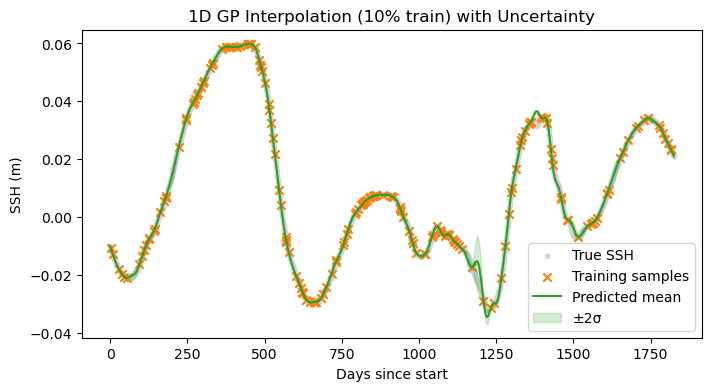

In [15]:
plt.figure(figsize=(8,4))
plt.scatter(X_time,y_time,c="lightgray", marker=".", label="True SSH")
plt.scatter(X_train,y_train,c="C1", marker="x", label="Training samples")
plt.plot(X_test,y_pred,c="C2", label="Predicted mean" )
plt.fill_between(X_test.ravel(),y_pred - 2*y_std,y_pred + 2*y_std,color="C2", alpha=0.2, label="±2σ")
plt.xlabel("Days since start")
plt.ylabel("SSH (m)")
plt.title("1D GP Interpolation (10% train) with Uncertainty")
plt.legend()
plt.show()

### Plot summary

#### True vs. Predicted Scatter Plot

The blue points lie almost exactly on the dashed 45° line, confirming your GP is recovering held-out grid values with negligible bias or scatter.

#### Overlay plot

The red “×” (interpolated) sit right on top of the black dots (true), so visually it’s nailing the time-series shape.

## Spatial Interpolation 

In [22]:
t0     = ssh["t"].to_index()[0]
field  = ssh.sel(t=t0) 
lats   = field["x"].values
lons   = field["y"].values
XX, YY = np.meshgrid(lons, lats)

In [23]:
XXn = (XX - lons.min()) / (lons.max() - lons.min())
YYn = (YY - lats.min()) / (lats.max() - lats.min())
coords_norm = np.vstack([XXn.ravel(), YYn.ravel()]).T
vals        = field.values.ravel()

In [24]:
n_pts = coords_norm.shape[0]
k     = int(n_pts * 0.1)
idx   = np.random.choice(n_pts, k, replace=False)
train_coords = coords_norm[idx]
train_vals   = vals[idx]
test_coords  = np.delete(coords_norm, idx, axis=0)
test_vals    = np.delete(vals,     idx, axis=0)
print(f"Train pts: {len(train_coords)}, Test pts: {len(test_coords)}")

Train pts: 6553, Test pts: 58983


In [27]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np

# Reduce the dataset size if possible
# Option 1: Subsample your data
# For example, take every 10th point
subsample_factor = 10
train_coords_reduced = train_coords[::subsample_factor]
train_vals_reduced = train_vals[::subsample_factor]

# Option 2: Or use a more memory-efficient approach
amp_spat = np.var(train_vals)
kernel_spatial = (
    ConstantKernel(amp_spat, (1e-3*amp_spat, 1e3*amp_spat))
    * RBF(length_scale=0.05, length_scale_bounds=(1e-3, 0.5))
    + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-12, 1e-2))
)

# Use a sparse GP implementation if available
# Or set a lower n_restarts_optimizer to reduce memory usage
gp_2d = GaussianProcessRegressor(
    kernel=kernel_spatial, 
    n_restarts_optimizer=5,  # Reduced from 10
    normalize_y=True  # This can help with numerical stability
)

# Fit with the reduced dataset
gp_2d.fit(train_coords_reduced, train_vals_reduced)
print("Learned kernel:", gp_2d.kernel_)

Learned kernel: 0.694**2 * RBF(length_scale=0.0359) + WhiteKernel(noise_level=0.0013)


C:\Users\ABHISHEK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 0.48161139979954903. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [28]:
def batch_predict_std(model, X, bs=2000):
    ms, ss = [], []
    for i in range(0, len(X), bs):
        Xb = X[i : i + bs]
        m, s = model.predict(Xb, return_std=True)
        ms.append(m)
        ss.append(s)
    return np.concatenate(ms), np.concatenate(ss)

In [29]:
pred_means, pred_stds = batch_predict_std(gp_2d, test_coords, bs=2000)
mse_2d = mean_squared_error(test_vals, pred_means)
print(f"2D interpolation MSE = {mse_2d:.6f}")

2D interpolation MSE = 0.000021


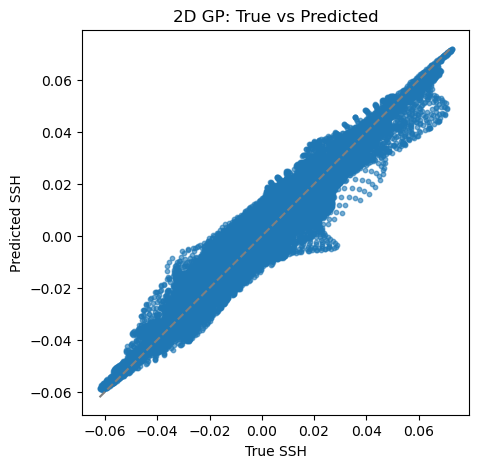

In [30]:
# 6. Plot True vs Predicted scatter
plt.figure(figsize=(5,5))
plt.scatter(test_vals, pred_means, s=10, alpha=0.6)
lims = [test_vals.min(), test_vals.max()]
plt.plot(lims, lims, "--", color="gray")
plt.xlabel("True SSH"); plt.ylabel("Predicted SSH")
plt.title("2D GP: True vs Predicted")
plt.show()

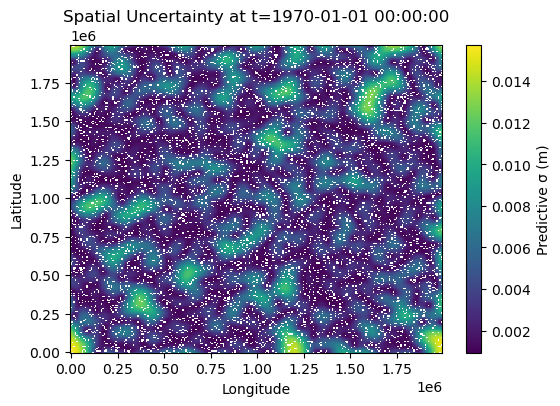

In [31]:
std_field = np.full(vals.shape, np.nan)
std_field[np.delete(np.arange(n_pts), idx)] = pred_stds
std_field = std_field.reshape(XX.shape)

plt.figure(figsize=(6,4))
plt.pcolormesh(XX, YY, std_field, cmap="viridis", shading="auto")
plt.colorbar(label="Predictive σ (m)")
plt.title(f"Spatial Uncertainty at t={t0}")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()
